In [12]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

In [13]:
FOLDER = 'E:/diss/reuters/'
GRAPHS = 'C:/Users/Mr Barrett/Dropbox/Diss/graphs/'

In [5]:
lbltype_counts = pd.read_csv(FOLDER + "val_lblcounts.csv").set_index("lbltype_name")
lbltype_counts.sort_values("num_val", inplace=True)
lbltype_counts

,num_val
lbltype_name,
nickel,1
platinum,1
nkr,1
retail,1
housing,1
...,...
grain,68
money-fx,82
crude,99


In [14]:
num_partitions = 4
num_lbltypes = len(lbltype_counts)
partition_size = num_lbltypes // num_partitions

lbltype_partitions = []
for i in range(num_partitions):
    end = num_lbltypes if i == num_partitions - 1 else (i + 1) * partition_size
    lbltype_partitions.append(list(lbltype_counts.index[i * partition_size: end]))


In [15]:
name_update = {
    'bert-init_state=bert-base-uncased,comp=L2R,chunking=2,max_len_comp=64': 'BERT-L2R',
    'bert-init_state=bert-base-uncased,comp=L2R,chunking=4,max_len_comp=128': 'BERT-L2R-2',
    'bert-init_state=bert-base-uncased,comp=cutting-sort,chunking=2,blocking=8,max_len_comp=64': 'BERT-Cut-Sort',
    'bert-init_state=bert-base-uncased,comp=cutting-sort,chunking=4,blocking=16,max_len_comp=128': 'BERT-Cut-Sort-2',
}
name_update = {
    'bert-init_state=bert-base-uncased,comp=L2R,chunking=2,max_len_comp=64': 'bzip2',
    'bert-init_state=bert-base-uncased,comp=L2R,chunking=4,max_len_comp=128': 'lzma',
    'bert-init_state=bert-base-uncased,comp=cutting-sort,chunking=2,blocking=8,max_len_comp=64': 'zlib',
    'bert-init_state=bert-base-uncased,comp=cutting-sort,chunking=4,blocking=16,max_len_comp=128': 'gzip',
    'gzip': 'BERT-Cut-Sort-2',
    'zlib': 'BERT-Cut-Sort',
    'lzma': 'BERT-L2R-2',
    'bzip2': 'BERT-L2R',
}

In [16]:
df = pd.read_csv(FOLDER + "reuters_accs.csv")
df

,lbltype_name,compname,ncd_formula,predictor,seqpart,seqpart_size,num_instances,tp,tn,fp,fn
0,acq,bzip2,norm-inf-dist-1,AVG,0,7769,1650,1650,6119,0,0
1,acq,bzip2,norm-inf-dist-1,AVG,1,1510,357,207,678,469,148
2,acq,bzip2,norm-inf-dist-1,AVG,2,1509,362,209,688,448,146
3,acq,gzip,norm-inf-dist-1,AVG,0,7769,1650,1650,6119,0,0
4,acq,gzip,norm-inf-dist-1,AVG,1,1510,357,194,670,477,161
...,...,...,...,...,...,...,...,...,...,...,...
1987,zinc,"bert-init_state=bert-base-uncased,comp=L2R,chu...",inf-dist,0.2-quantile,1,1510,8,3,1479,15,5
1988,zinc,"bert-init_state=bert-base-uncased,comp=L2R,chu...",inf-dist,0.2-quantile,2,1509,5,2,1477,9,3
1989,zinc,"bert-init_state=bert-base-uncased,comp=cutting...",norm-inf-dist-2,0.05-quantile,0,7769,21,21,7748,0,0
1990,zinc,"bert-init_state=bert-base-uncased,comp=cutting...",norm-inf-dist-2,0.05-quantile,1,1510,8,3,1472,22,5


In [17]:
df["modal_acc"] = 1.0 - df["num_instances"] / df["seqpart_size"]
df["acc"] = (df["tp"] + df["tn"]) / df["seqpart_size"]
df["precision"] = df["tp"] / (df["tp"] + df["fp"])
df["recall"] = df["tp"] / (df["tp"] + df["fn"])
df["f1"] = df["tp"] / (df["tp"] + 0.5 * (df["fp"] + df["fn"]))

In [18]:
df["compname"] = df["compname"].apply(lambda s: name_update[s] if s in name_update else s)

In [19]:
colours = {
    'bzip2': 'tab:blue',
    'gzip': 'tab:blue',
    'lzma': 'tab:blue',
    'zlib': 'tab:blue',
    'BERT-L2R': 'tab:orange',
    'BERT-L2R-2': 'tab:orange',
    'BERT-Cut-Sort': 'tab:orange',
    'BERT-Cut-Sort-2': 'tab:orange',
}

In [20]:
df_val = df[df["seqpart"] == 1]
df_test = df[df["seqpart"] == 2]

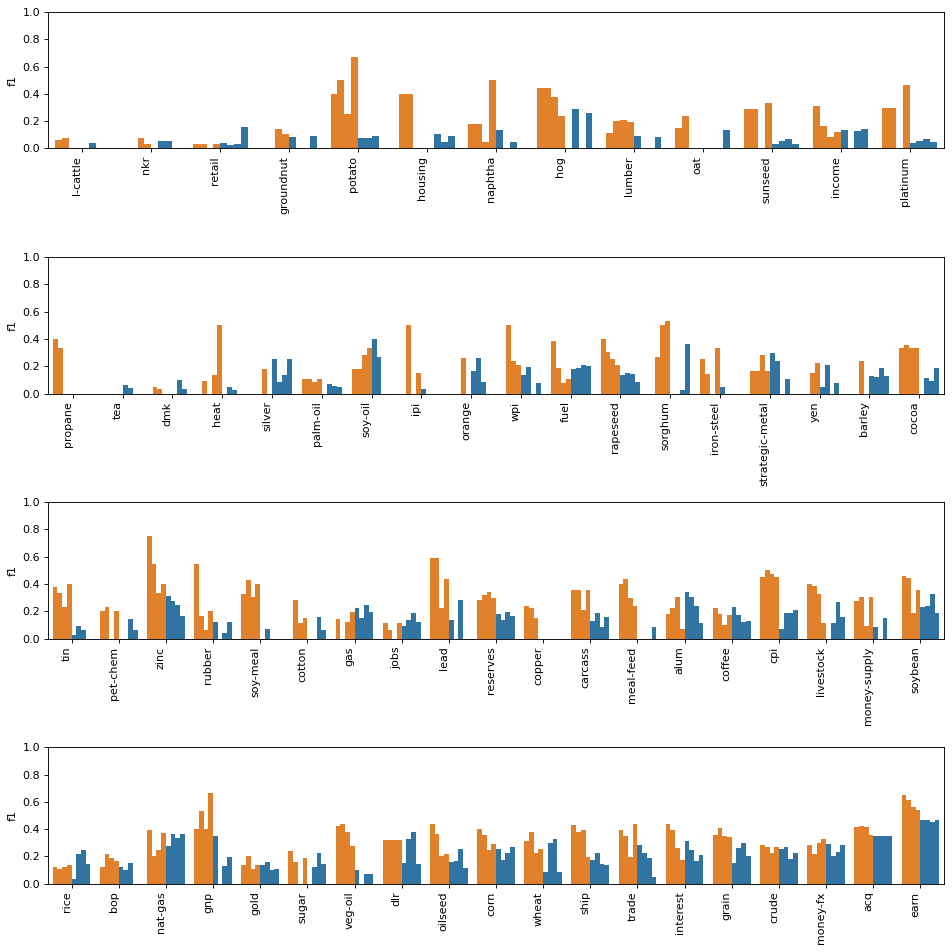

In [21]:
y_axis = "f1"
fig, axs = plt.subplots(len(lbltype_partitions), 1, figsize=(12, 12), dpi=80)

for i, lbltype_partition in enumerate(lbltype_partitions):
    df_partition = df_test[df_test["lbltype_name"].apply(lambda s: s in lbltype_partition)]
    df_partition = df_partition.sort_values(["num_instances", "compname"])
    sns.barplot(data=df_partition,
                x="lbltype_name", y=y_axis, ax=axs[i],
                hue="compname", palette=colours)

    axs[i].set_xlabel('')
    axs[i].set_ylabel(y_axis)
    axs[i].set_ylim((0.0, 1.0))
    axs[i].legend().remove()
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90, ha='right')

fig.tight_layout()
plt.show()

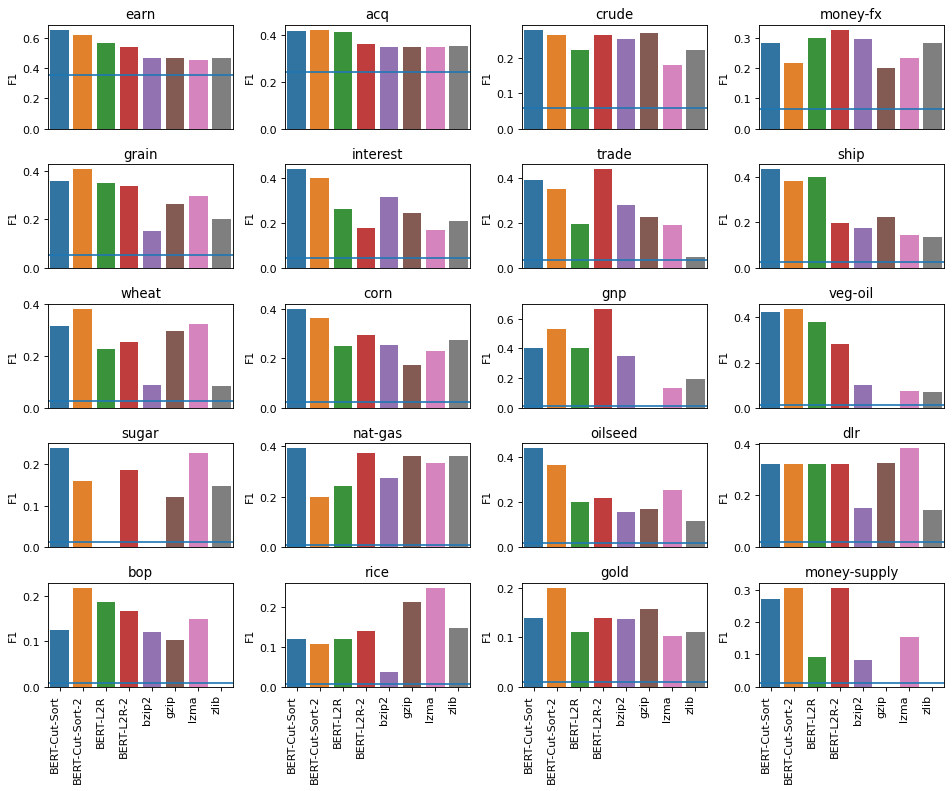

In [24]:
num = 20
row = 4
assert(num % row == 0)
lbltypes = list(lbltype_counts.index)[::-1][:num]

fig, axs = plt.subplots(num // row, row, figsize=(3 * row, 2 * (num // row)), dpi=80)

for i in range(num // row):
    for j, lbltype in enumerate(lbltypes[i * row : (i + 1) * row]):
        df_partition = df_test[df_test["lbltype_name"] == lbltype]
        df_partition = df_partition.sort_values(["num_instances", "compname"])
        sns.barplot(data=df_partition, ax=axs[i][j],
                    x="compname", y="f1")

        axs[i][j].set_title(lbltype)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel("F1")
        axs[i][j].axhline(y=(df_partition["num_instances"] / df_partition["seqpart_size"]).values[0])
        axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), rotation=90, ha='right')
        if i != num // row - 1:
            axs[i][j].set_xticks([])

fig.tight_layout()
plt.savefig(GRAPHS + f"reuters-classification.svg", format="svg", bbox_inches='tight')
plt.show()

In [4]:
df = pd.read_csv(FOLDER + "reuters_cuts.csv")
df_val = df[df['seqpart'] == 1]
df_test = df[df['seqpart'] == 2]

In [5]:
df_val[df_val['emp_prob'] < 0.05]["lbltype_name"].unique()

array(['lead', 'wheat'], dtype=object)

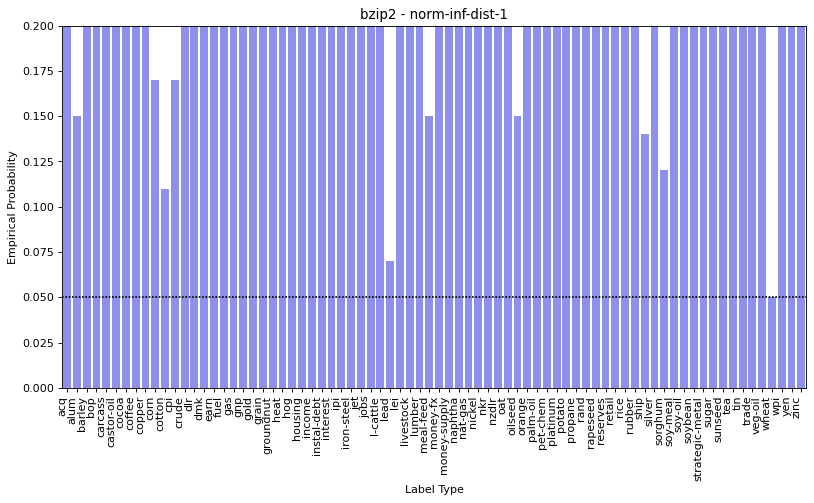

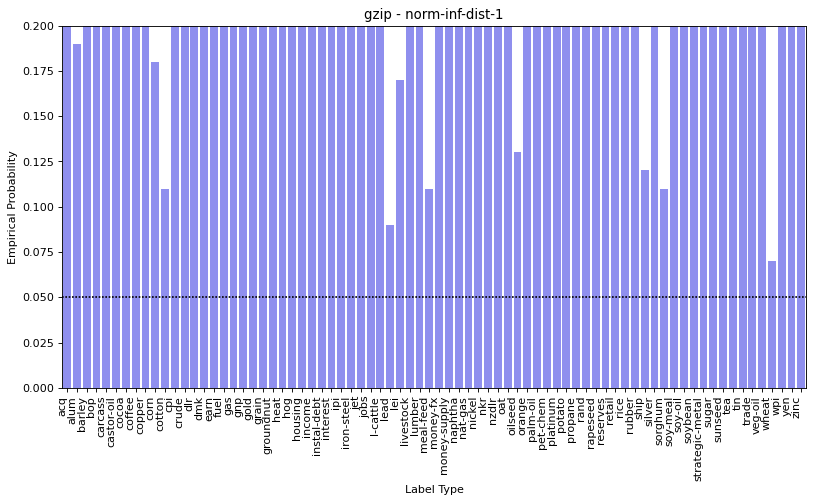

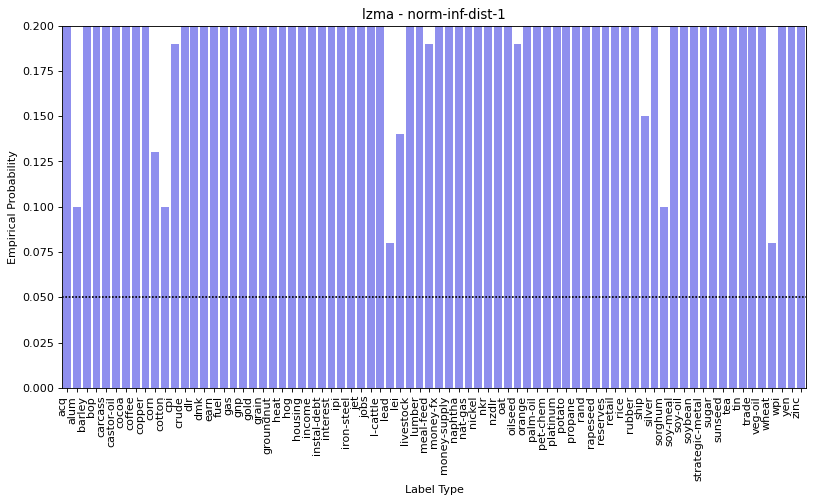

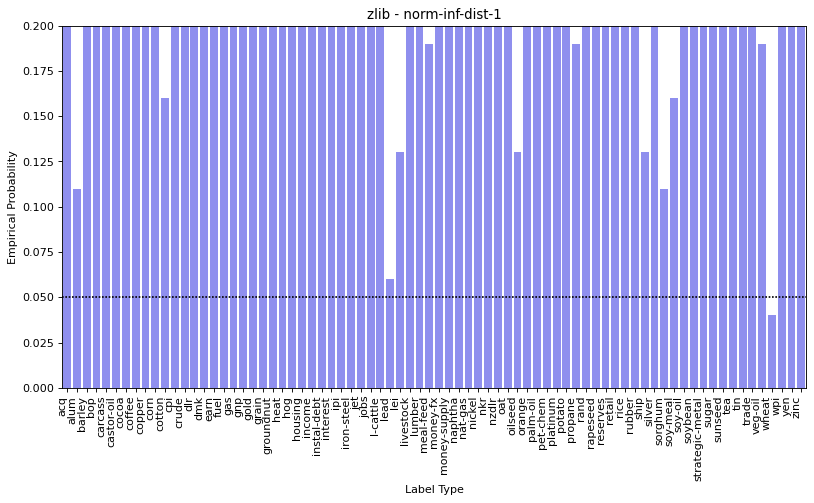

In [7]:
for compname in df_val['compname'].unique():
    ncd_formula = 'norm-inf-dist-1'
    plt.gcf().set_size_inches((12, 6))
    plt.gcf().set_dpi(80)
    plt.ylim((0.0, 0.2))
    sns.barplot(data=df_val[(df_val["compname"] == compname) & (df_val["ncd_formula"] == ncd_formula)
                            & pd.notnull(df_val["emp_prob"])],
                x="lbltype_name", y="emp_prob", color='b', alpha=0.5)
    #sns.barplot(data=df_test[(df_test["compname"] == compname) & (df_test["ncd_formula"] == ncd_formula)],
    #            x="lbltype_name", y="emp_prob", color='r', alpha=0.5)
    plt.axhline(y=0.05, color='black', dashes=(1, 1))
    plt.xlabel('Label Type')
    plt.ylabel('Empirical Probability')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='right')
    plt.title(compname + " - " + ncd_formula)
    plt.show()

In [3]:
df = pd.read_csv(FOLDER + "mst_cut_hulls.csv")
df = df[df["dist_aggregator"] == "mp"]
df["over_baseline"] = df["hull_area"] - df["baseline_hull_area"]
df_val = df[df["seqpart"] == 1]
df_test = df[df["seqpart"] == 2]

In [6]:
with pd.option_context('display.max_rows', 200):
    df_val_counts = df_val.join(lbltype_counts, on="lbltype_name")
    print(df_val_counts[(df_val_counts["compname"] == "gzip")
                 & (df_val_counts["ncd_formula"] == "mutual-inf-esque")][
        ["lbltype_name", "num_val", "over_baseline"]])

         lbltype_name  num_val  over_baseline
1800              acq    357.0       0.001540
1801             alum     10.0       0.050848
1802           barley      4.0       0.124697
1803              bop     17.0       0.031176
1804          carcass      8.0       0.063555
1805       castor-oil      1.0       0.499669
1806            cocoa      4.0       0.125062
1807          coconut      NaN       0.000000
1808      coconut-oil      NaN       0.000000
1809           coffee     14.0       0.035438
1810           copper      9.0       0.055624
1811       copra-cake      NaN       0.000000
1812             corn     25.0       0.019701
1813           cotton     13.0       0.039702
1814       cotton-oil      NaN       0.000000
1815              cpi     14.0       0.036033
1816              cpu      NaN       0.000000
1817            crude     99.0       0.005133
1818              dfl      NaN       0.000000
1819              dlr     17.0       0.029232
1820              dmk      2.0    

        lbltype_name  num_val  over_baseline
720              acq      357       0.001618
721             alum       10       0.049928
722           barley        4       0.124863
723              bop       17       0.030117
724          carcass        8       0.062622
725       castor-oil        1       0.499669
726            cocoa        4       0.125118
729           coffee       14       0.035406
730           copper        9       0.055681
732             corn       25       0.060431
733           cotton       13       0.038907
735              cpi       14       0.035406
737            crude       99       0.004892
739              dlr       17       0.029109
740              dmk        2       0.249734
741             earn      555       0.001424
742             fuel        3       0.166450
743              gas        9       0.055455
744              gnp       20       0.025899
745             gold       15       0.033406
746            grain       68       0.021180
747       

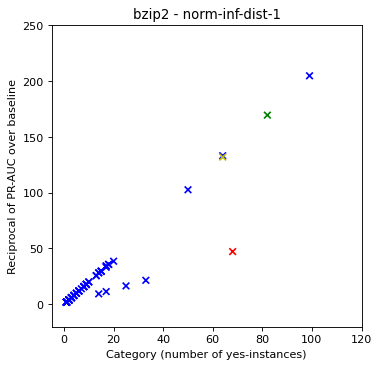

         lbltype_name  num_val  over_baseline
2880              acq      357       0.001304
2881             alum       10       0.049750
2882           barley        4       0.124709
2883              bop       17       0.029292
2884          carcass        8       0.062560
2885       castor-oil        1       0.499669
2886            cocoa        4       0.124709
2889           coffee       14       0.035555
2890           copper        9       0.055671
2892             corn       25       0.039642
2893           cotton       13       0.038289
2895              cpi       14       0.035555
2897            crude       99       0.004849
2899              dlr       17       0.087295
2900              dmk        2       0.249725
2901             earn      555       0.002659
2902             fuel        3       0.166447
2903              gas        9       0.055330
2904              gnp       20       0.025730
2905             gold       15       0.033187
2906            grain       68    

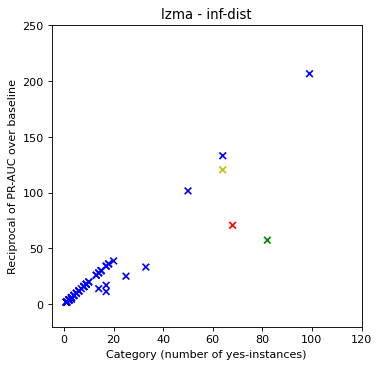

         lbltype_name  num_val  over_baseline
1800              acq      357       0.001540
1801             alum       10       0.050848
1802           barley        4       0.124697
1803              bop       17       0.031176
1804          carcass        8       0.063555
1805       castor-oil        1       0.499669
1806            cocoa        4       0.125062
1809           coffee       14       0.035438
1810           copper        9       0.055624
1812             corn       25       0.019701
1813           cotton       13       0.039702
1815              cpi       14       0.036033
1817            crude       99       0.005133
1819              dlr       17       0.029232
1820              dmk        2       0.249800
1821             earn      555       0.002073
1822             fuel        3       0.166731
1823              gas        9       0.055297
1824              gnp       20       0.028430
1825             gold       15       0.033135
1826            grain       68    

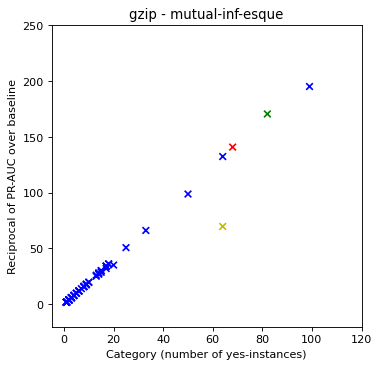

In [11]:
for compname, ncd_formula in [('bzip2', 'norm-inf-dist-1'), ('lzma', 'inf-dist'), ('gzip', 'mutual-inf-esque')]:
    df_current = df_val[(df_val["compname"] == compname) & (df_val["ncd_formula"] == ncd_formula)]
    df_current = df_current[df_current["over_baseline"] > 0.0]
    df_current["colour"] = df_current["lbltype_name"].apply(lambda x:
        'r' if x == 'grain' else 'g' if x == 'money-fx'
        else 'y' if x == 'trade' else 'b')
    df_current = df_current.join(lbltype_counts, on="lbltype_name")
    with pd.option_context('display.max_rows', 200):
        print(df_current[["lbltype_name", "num_val", "over_baseline"]])
    plt.gcf().set_size_inches((5, 5))
    plt.gcf().set_dpi(80)
    plt.scatter(df_current["num_val"], df_current["over_baseline"].apply(lambda x: 1.0 / x),
                marker='x', color=df_current["colour"])
    #sns.barplot(data=df_current,
    #            x="lbltype_name", y="over_baseline", color='b', alpha=0.5)
    #sns.barplot(data=df_test[(df_test["compname"] == compname) & (df_test["ncd_formula"] == ncd_formula)],
    #            x="lbltype_name", y="over_baseline", color='r', alpha=0.5)
    # plt.axline((0.0, 0.0), (200.0, 400.0), dashes=(1.0, 1.0))
    plt.xlim((-5, 120))
    plt.ylim((-20, 250))
    plt.xlabel('Category (number of yes-instances)')
    plt.ylabel('Reciprocal of PR-AUC over baseline')
    plt.title(compname + " - " + ncd_formula)
    plt.savefig(GRAPHS + f"reuters-cut-{compname}-{ncd_formula}.svg", format="svg", bbox_inches='tight')
    plt.show()